In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.optimizers import Adam, RMSprop
from keras.models import Model, Sequential
from keras.metrics import mean_absolute_error, mae, mse
from keras.layers import Dense, Dropout, Input
from keras.regularizers import l2, l1_l2

from datetime import datetime

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def load_data(url, columns=[1, 2, 4, 6, 11]):
  """ Load the dataset, change the column names, 
      and replace the categorical data by numeric values
  """
  # load data
  df = pd.read_csv(url, header=None, usecols=columns)
  print('Data shape: ', np.shape(df))

  # re-name all columns
  column_names = ['Price', 'PurchaseDate', 'PropertyType', 'LeaseDuration', 'City']
  df.columns = column_names
  
  # resplace column values
  df['PropertyType'] = df['PropertyType'].replace({'F':0, 'D':1, 'S':2, 'T':3, 'O':4})
  df['LeaseDuration'] = df['LeaseDuration'].replace({'L':0, 'F':1, 'U':2})
  df.loc[df['City']=='LONDON', 'City'] = 0
  df.loc[df['City'] != 0, 'City'] = 1

  # convert column values to appropriate dtype (to save memory)
  df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])
  df['Price'] = pd.to_numeric(df["Price"], downcast="integer")
  df['PropertyType'] = pd.to_numeric(df['PropertyType'], downcast='integer')
  df['LeaseDuration'] = pd.to_numeric(df["LeaseDuration"], downcast="integer")
  df['City'] = pd.to_numeric(df["City"], downcast="integer")

  return df

In [0]:
def split_train_test(df):
  """ Split the data into training and test dataset 
  """
  # purchases prior to 1/1/2016 as training
  cutoff = datetime(2016, 1, 1)
  column_sels = ['Price', 'PropertyType', 'LeaseDuration', 'City']
  train_df = df.loc[df['PurchaseDate'] <= cutoff][column_sels]
  test_df = df.loc[df['PurchaseDate'] > cutoff][column_sels] 
  print("Train shape: ", train_df.shape)
  print("Test shape: ", test_df.shape)
  
  # remove duplicates
  train_df.drop_duplicates(keep='first', inplace=True)
  test_df.drop_duplicates(keep='first', inplace=True)
  print("After duplicates removed: \n\tTrain shape: ", train_df.shape)
  print("\tTest shape: ", test_df.shape)

  return train_df, test_df  

In [0]:
def split_train_val(train_df, perc=0.2):
  """ Split the training into (partial) train and val data (~20% default)
  """
  # split to train and val
  train_df, val_df = train_test_split(train_df, test_size=perc, random_state=2019)
  print("Train shape : ", train_df.shape)
  print("Test shape : ", test_df.shape)
  
  return train_df, val_df  

In [0]:
def prep(train_df, val_df, test_df):
  """ Prepare inputs/targets pair for training, val, and testing
      using one-hot encoding (for categorical data), and 
      down-scale the target values (prices) 
  """
  # training data
  train_X = train_df[['PropertyType', 'LeaseDuration', 'City']]
  train_y = train_df['Price']

  val_X = val_df[['PropertyType', 'LeaseDuration', 'City']]
  val_y = val_df['Price']

  # testing data
  test_X = test_df[['PropertyType', 'LeaseDuration', 'City']]
  test_y = test_df['Price']

  # one-hot encoding the inputs
  ohc = OneHotEncoder(handle_unknown='ignore')
  ohc.fit(train_X)
  train_X = ohc.transform(train_X)
  val_X = ohc.transform(val_X)
  test_X = ohc.transform(test_X)

  # convert the targets to smaller range
  train_y = np.log1p(train_y * 1e-3)
  val_y = np.log1p(val_y * 1e-3)
  test_y = np.log1p(test_y * 1e-3)

  return (train_X, train_y), (val_X, val_y), (test_X, test_y)  

In [0]:
def build_model(input_size, l_rate=1e-3):
  """ Build and compile a fully-connected neural network 
  """
  inp = Input(shape=(input_size,))
  fc1 = Dense(100, activation='relu', kernel_regularizer=l2(0.001))(inp)
  do1 = Dropout(0.5)(fc1)
  fc2 = Dense(200, activation='relu', kernel_regularizer=l2(0.001))(do1)
  do2 = Dropout(0.5)(fc2)
  fc3 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(do2)
  do3 = Dropout(0.5)(fc3)
  fc4 = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(do3)
  out = Dense(1)(fc4)

  model = Model(inputs=inp, outputs=out)
  print(model.summary())
  model.compile(optimizer=RMSprop(lr=l_rate), loss=mse, metrics=[mae])
  
  return model

In [0]:
def train_model(model, epchs=50, b_size=512, v_bose=1):
  """ Train a compiled model
  """
  history = model.fit(train_X, train_y, batch_size=b_size, verbose=v_bose,
                      epochs=epchs, validation_data=(val_X, val_y))
  
  train_mae = history.history['mean_absolute_error']
  val_mae = history.history['val_mean_absolute_error']
  
  return train_mae, val_mae

In [0]:
def plot_train_val_error(train_errs, val_errs):
  """ Plot the train/val loss over epochs
  """
  epochs = len(train_errs)
  plt.plot(range(1, epochs+1), train_errs, label='Training Loss')
  plt.plot(range(1, epochs+1), val_errs, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [0]:
def smooth_curve(points, factor=0.9):
  """ Smooth with an exponential moving average
  """
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous*factor + point*(1-factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

# **Loading and Pre-processing**

In [11]:
# load and pre-processing
url = '/content/drive/My Drive/pp-complete.csv'
df = load_data(url)
train_df, test_df = split_train_test(df)

Data shape:  (24852949, 5)
Train shape:  (21018083, 4)
Test shape:  (3834866, 4)
After duplicates removed. 
	Train shape:  (317952, 4)
	Test shape:  (144006, 4)


# **Training the model with k-fold cross-validation**

In [12]:
# fitting the model using cross validation with k folds
k = 5
num_samples = train_df.shape[0] // k
num_epochs = 50
b_size = 512
train_errors = []
val_errors = []

for i in range(k):
  print('Processing fold {0}'.format(i))

  # prepare train and val data
  val_data = train_df.iloc[i*num_samples: (i+1)*num_samples]
  train_data = pd.concat([train_df.iloc[:i*num_samples], train_df.iloc[(i+1)*num_samples:]])
  (train_X, train_y), (val_X, val_y), _ = prep(train_data, val_data, test_df)

  # build a new model
  model = build_model(train_X.shape[1])
  train_mae, val_mae = train_model(model, num_epochs, b_size, v_bose=1)

  # append train/val errors to error lists
  train_errors.append(train_mae)
  val_errors.append(val_mae)

Processing fold 0




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

# **Examining the train/val errors**

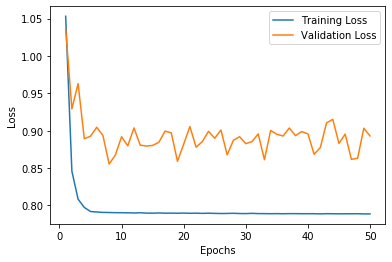

In [13]:
avg_train = [np.mean(i) for i in zip(*train_errors)]
avg_val = [np.mean(i) for i in zip(*val_errors)]
plot_train_val_error(avg_train, avg_val)

It is quite difficult to see the plot as the scaling issues and relatively high variance. We will replace each point with an exponential moving average of the previous points to obtain a smooth curve.

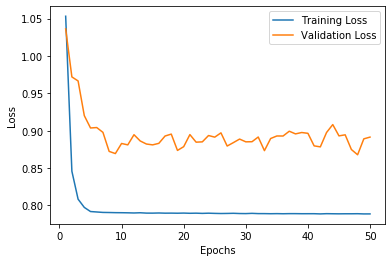

In [19]:
smooth_avg_val = smooth_curve(avg_val, factor=0.4)
plot_train_val_error(avg_train, smooth_avg_val)

# **Final model**
It seems that the validation MAE stops inproving after 10 epochs. Past that point, we start overfitting. We will build the final model, where we train it for only 10 epochs on the whole training dataset. In the end, we test the trained model on our test data.

In [0]:
# prepare train, validation and test data
(train_X, train_y), _, (test_X, test_y)  = prep(train_df, test_df, test_df)

In [22]:
# build and train the model
model = build_model(np.shape(train_X)[1])
model.fit(train_X, train_y, epochs=10, batch_size=512, verbose=1)


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               1100      
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 200)               20200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0   

In [23]:
# evaluate the trained model on test data
test_mse_score, test_mae_score = model.evaluate(test_X, test_y)
print("Test MAE Score: ", test_mae_score)

144006/144006 [==============================] - 10s 73us/step
Test MAE Score:  1.0370007480915813


We are still off by about £1820.00. Note that we scaled down the prices to thousands and then applied the `np.log1p` function to transform the data. To obtain the offset in price, we only need to inverse the process using the formula: $\text{price-offset} \approx 1000\cdot (e^{\text{MAE_SCORE}}-1)$.